In [1]:

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import os
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

2025-08-12 02:55:50.200817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754967350.390462      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754967350.444636      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir  = '/kaggle/input/garbage-classification-v2/garbage-dataset'
classes = os.listdir(data_dir)
print(classes)

['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']


In [3]:
import os
import numpy as np
import shutil

# Define paths and classes
rootdir = '/kaggle/input/garbage-classification-v2/garbage-dataset'  # Original dataset path
rootdir1 = './Train-TestSplit/'  # Output directory
classes = ['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']

# Create train/test directories (75% train, 25% test)
for cls in classes:
    os.makedirs(rootdir1 + 'train/' + cls, exist_ok=True)
    os.makedirs(rootdir1 + 'test/' + cls, exist_ok=True)
    
    source = os.path.join(rootdir, cls)
    all_files = os.listdir(source)
    np.random.shuffle(all_files)
    
    split_idx = int(len(all_files) * 0.75)
    train_files, test_files = all_files[:split_idx], all_files[split_idx:]
    
    for f in train_files:
        shutil.copy(os.path.join(source, f), os.path.join(rootdir1, 'train', cls, f))
    for f in test_files:
        shutil.copy(os.path.join(source, f), os.path.join(rootdir1, 'test', cls, f))

In [4]:
TRAINING_DIR='/kaggle/working/train'
TEST_DIR='/kaggle/working/test'
im_shape = (299,299)
seed = 10
BATCH_SIZE = 32

In [5]:
# Training generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Validation/test generator (no augmentation)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)



In [6]:
# Define constants at the top of your notebook
IMG_SIZE = (299, 299)  # Input size for InceptionResNetV2
BATCH_SIZE = 32        # Reduced from 1024 for better memory usage
CLASSES = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 
           'metal', 'paper', 'plastic', 'shoes', 'trash']

# Data generators with proper variable usage
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    './Train-TestSplit/train',
    target_size=IMG_SIZE,  # Now using the defined constant
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,       # Explicitly specify classes
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    './Train-TestSplit/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='validation'
)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    './Train-TestSplit/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    shuffle=False
)

Found 11857 images belonging to 10 classes.
Found 2961 images belonging to 10 classes.
Found 4944 images belonging to 10 classes.


In [7]:
from tensorflow.keras.layers import Dense, Flatten, Dropout  # Make sure Dropout is imported
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.optimizers import Adam

# Base model (pretrained)
base_model = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)  # Using direct dimensions instead of *IMG_SIZE
)

# Freeze base layers
base_model.trainable = False

# Custom head for 10 classes
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Now properly defined
output = Dense(10, activation='softmax')(x)

model = Model(base_model.input, output)
model.compile(optimizer=Adam(learning_rate=0.001),  # Explicit learning rate
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

I0000 00:00:1754967702.720963      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754967702.722016      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 104,674,026 (399.30 MB)

 Trainable params: 50,337,290 (192.02 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [ ]:
# Calculate dataset sizes
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

epochs = 20

# Enhanced Callbacks
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='garbage_classifier_10class.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1),
    
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        mode='max',
        restore_best_weights=True,
        verbose=1),
    
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1)
]

# Training with properly calculated steps
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, nb_train_samples // BATCH_SIZE),
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=max(1, nb_validation_samples // BATCH_SIZE),
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1754967803.248079     119 service.cc:148] XLA service 0x7849040021c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754967803.248959     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754967803.248981     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754967808.234448     119 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754967822.737887     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.6649 - loss: 6.9278
Epoch 1: val_accuracy improved from -inf to 0.83016, saving model to garbage_classifier_10class.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 477s 1s/step - accuracy: 0.6651 - loss: 6.9157 - val_accuracy: 0.8302 - val_loss: 0.5814 - learning_rate: 0.0010
Epoch 2/20
  1/370 ━━━━━━━━━━━━━━━━━━━━ 2:07 346ms/step - accuracy: 0.6562 - loss: 1.3478

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.83016
370/370 ━━━━━━━━━━━━━━━━━━━━ 71s 192ms/step - accuracy: 0.6562 - loss: 1.3478 - val_accuracy: 0.8237 - val_loss: 0.6000 - learning_rate: 0.0010
Epoch 3/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.7513 - loss: 0.8222
Epoch 3: val_accuracy improved from 0.83016 to 0.84205, saving model to garbage_classifier_10class.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.7513 - loss: 0.8222 - val_accuracy: 0.8421 - val_loss: 0.5238 - learning_rate: 0.0010
Epoch 4/20
  1/370 ━━━━━━━━━━━━━━━━━━━━ 2:18 375ms/step - accuracy: 0.8438 - loss: 0.4258
Epoch 4: val_accuracy improved from 0.84205 to 0.84341, saving model to garbage_classifier_10class.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 92s 248ms/step - accuracy: 0.8438 - loss: 0.4258 - val_accuracy: 0.8434 - val_loss: 0.5131 - learning_rate: 0.0010
Epoch 5/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.7985 - loss: 0.7005
Epoch 5: val_accuracy improved from 0.8434

In [12]:
#model.save('model.keras')
# 7. Save the final model
model.save('final_garbage_classifier.h5')
print("Training completed and model saved!")

Training completed and model saved!


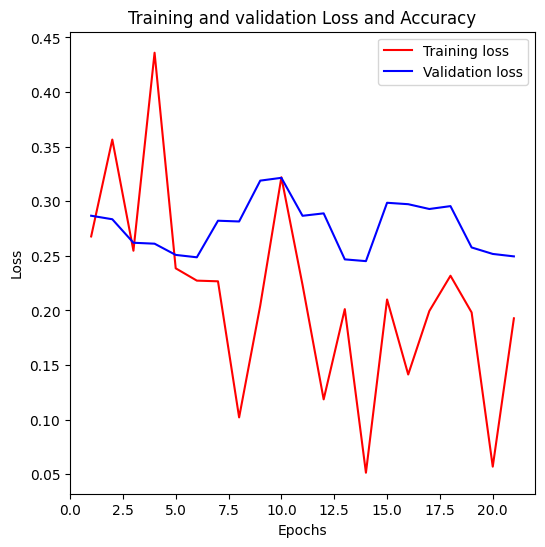

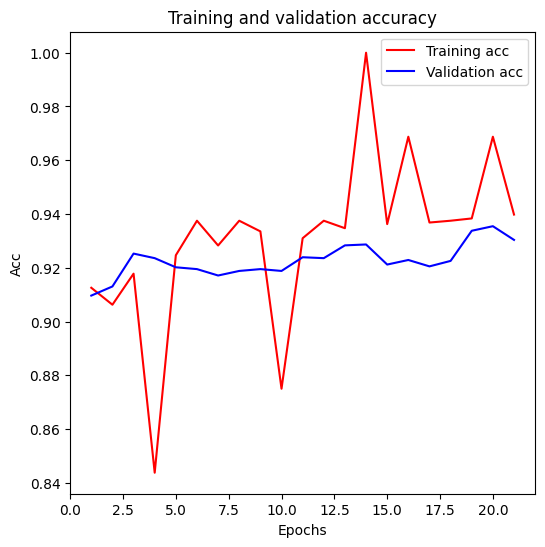

In [36]:

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(6,6))
#plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'r', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('EpochVsLoss.jpg',dpi = 300, bbox_inches='tight')
plt.show()
plt.figure(figsize=(6,6))
#plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'r', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.savefig('EpochVsAcc.jpg',dpi = 300, bbox_inches='tight')
plt.show()

In [37]:
from tensorflow.keras.models import load_model
model = load_model('model.keras')

In [ ]:
score = model.evaluate(train_generator)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

 43/371 ━━━━━━━━━━━━━━━━━━━━ 3:41 674ms/step - accuracy: 0.9515 - loss: 0.1633

In [20]:
score = model.evaluate(train_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

371/371 ━━━━━━━━━━━━━━━━━━━━ 256s 690ms/step - accuracy: 0.9160 - loss: 0.2582
Val loss: 0.2518497407436371
Val accuracy: 0.917938768863678


In [1]:
import pickle
labels = train_generator.class_indices
    # Invert labels
classes1 = {}
for key, value in labels.items():
    classes1[value] = key.capitalize()
# Save classes to file
with open('classes.pkl', 'wb') as file:
    pickle.dump(classes1, file)
print('Saved classes to disk!')

NameError: name 'train_generator' is not defined

In [22]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Conf.jpg',dpi = 300, bbox_inches='tight')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 80s 441ms/step
Classification Report
              precision    recall  f1-score   support

     battery       0.96      0.92      0.94       236
  biological       0.93      0.97      0.95       250
   cardboard       0.93      0.88      0.90       457
     clothes       1.00      0.98      0.99      1332
       glass       0.97      0.81      0.88       766
       metal       0.82      0.89      0.85       255
       paper       0.84      0.93      0.88       420
     plastic       0.71      0.94      0.81       496
       shoes       0.94      0.99      0.96       495
       trash       0.90      0.58      0.71       237

    accuracy                           0.91      4944
   macro avg       0.90      0.89      0.89      4944
weighted avg       0.92      0.91      0.91      4944



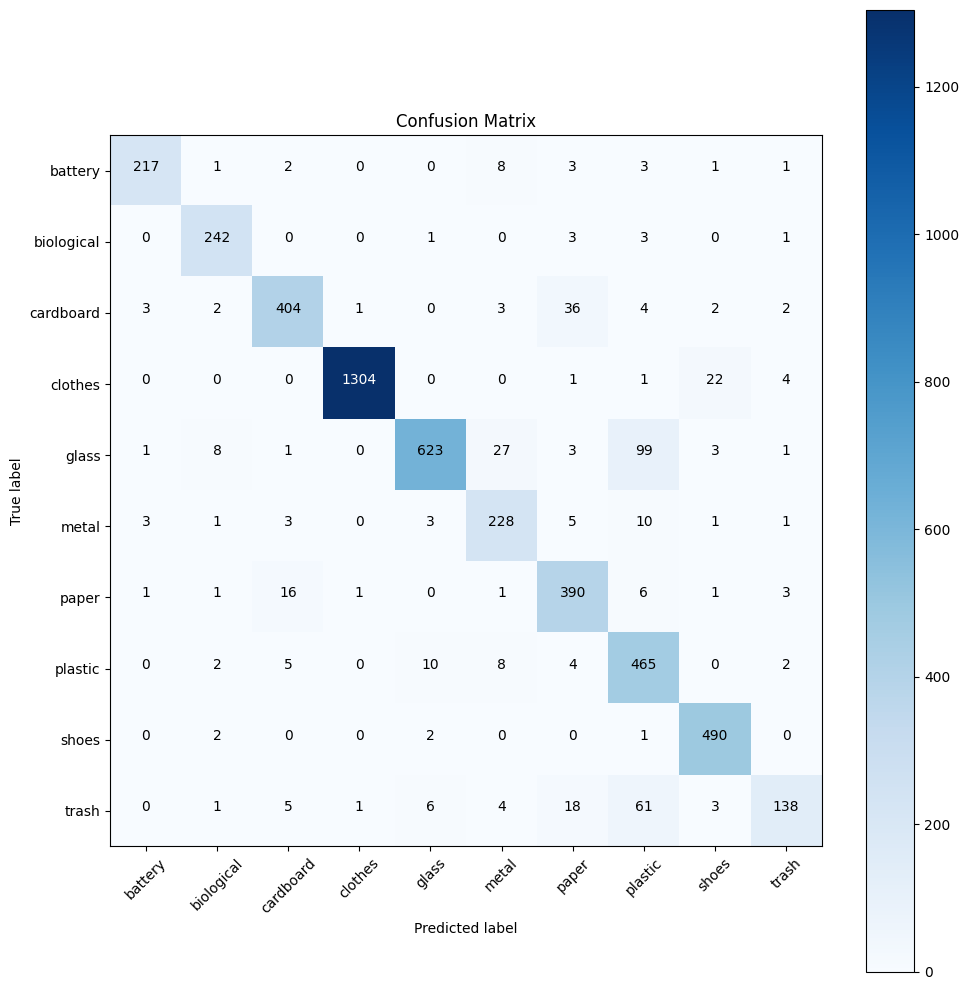

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes  # assuming classes = ['plastic', 'metal', 'paper'] or similar

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Plotting the Confusion Matrix
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))


In [25]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import random
import os
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

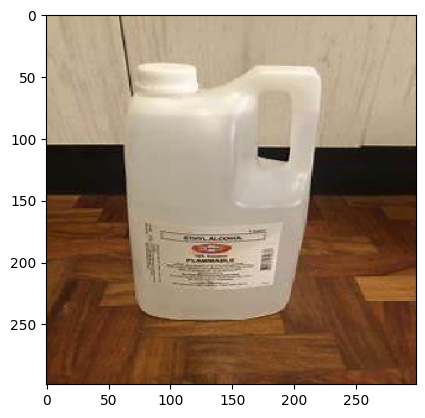

In [27]:
img_path = "/kaggle/working/test/plastic/plastic_1008.jpg"
img = image.load_img(img_path, target_size=(299,299))
plt.imshow(img)
plt.show()

In [28]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

In [30]:
import pickle
import numpy as np

# Predict using updated method
pred = model.predict(img_preprocessed)
pred1 = np.argmax(pred, axis=1)

# Load class labels
with open('./classes.pkl', 'rb') as file:
    classes_p = pickle.load(file)

# Print predicted class
print(classes_p[pred1[0]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
Plastic


In [31]:
!pip install gradio

In [4]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2

model = tf.keras.models.load_model('model.keras')  


class_names = ['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic'] 


def preprocess_image(image):
    img = cv2.resize(image, (299, 299))  
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img


def predict(image):
    img_array = preprocess_image(image)
    preds = model.predict(img_array)

    # If sigmoid: preds = [[0.88]]
    # If softmax: preds = [[0.1, 0.9]]
    if preds.shape[1] == 1:
        confidence = float(preds[0][0])
        label = class_names[1] if confidence > 0.5 else class_names[0]
        confidence_display = confidence if confidence > 0.5 else 1 - confidence
    else:
        class_index = int(np.argmax(preds[0]))
        label = class_names[class_index]
        confidence_display = float(np.max(preds[0]))

    return label, f"Confidence: {confidence_display:.2f}"


iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs=["text", "text"],
    title="Garbage Classifier",
)


iface.launch()

ValueError: File not found: filepath=model.keras. Please ensure the file is an accessible `.keras` zip file.